In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../../src')
from rdkit import Chem
from dfs_transformer.utils import Mol2Smiles, DFSCode2Graph, Graph2Mol, isValid, Smiles2DFSCode, DFSCode2Smiles, isValidMoleculeDFSCode
from dfs_transformer.utils import load_selfattn_wandb, load_selfattn_local
import os.path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import dfs_transformer as dfs
import numpy as np
from ml_collections import ConfigDict
import yaml
import functools
import tqdm

Using backend: pytorch


In [2]:
#pretrained_model = "r2r-nofeat-entrywise-10K"
pretrained_model = "r2r-2K"
force_download = False
if os.path.isdir("../../wandb/artifacts/%s"%pretrained_model) and not force_download:
    bert, cfg = load_selfattn_local("../../wandb/artifacts/%s"%pretrained_model)
else:
    bert, cfg = load_selfattn_wandb(pretrained_model, wandb_dir="../../wandb")

In [3]:
bert = bert.eval()

In [4]:
with open("../../config/selfattn/data/pubchem10K.yaml") as file:
    d = ConfigDict(yaml.load(file, Loader=yaml.FullLoader))

In [5]:
d

max_edges: 110
max_nodes: 110
molecular_properties: null
n_iter_per_split: 10
n_used: null
path: ./results/pubchem/noH/10K/
useDists: false
useHs: false
valid_path: ./results/pubchem/noH/validation/

In [6]:
d.no_features = cfg.data.no_features

In [7]:
if cfg.training.mode == "rnd2rnd":
    collate_fn = functools.partial(dfs.collate_BERT, 
                                   mode=cfg.training.mode, 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)
elif cfg.training.mode == "rnd2rnd_entry":
    collate_fn = functools.partial(dfs.collate_BERT_entries, 
                                   mode="rnd2rnd", 
                                   fraction_missing = cfg.training.fraction_missing,
                                   use_loops=cfg.model.use_loops)

In [8]:
validset = dfs.PubChem('../.'+d.valid_path, max_nodes=d.max_nodes, max_edges=d.max_edges, noFeatures=d.no_features,
                   molecular_properties=d.molecular_properties, useDists=d.useDists, useHs=d.useHs)
validloader = DataLoader(validset, batch_size=100, shuffle=False, 
                         pin_memory=True, collate_fn=collate_fn, num_workers=0,
                         prefetch_factor=2)

100%|████████████████████████████████████| 9978/9978 [00:00<00:00, 10788.77it/s]


In [9]:
device = torch.device('cuda:%d'%0 if torch.cuda.is_available() else 'cpu')
to_cuda = functools.partial(dfs.utils_to_cuda, device=device)

In [10]:
bert = bert.to(device)

In [11]:
data = next(iter(validloader))

In [12]:
data[0]['dfs_from'].shape

torch.Size([55, 100])

In [13]:
data[1].shape

torch.Size([55, 100, 8])

In [14]:
dfs_codes = []
for data in tqdm.tqdm(validloader):
    data = [to_cuda(d) for d in data]
    dfs_codes += bert.fwd_code(data[0], data[1], features=not cfg.data.no_features)

  1%|▍                                          | 1/100 [00:00<00:16,  5.99it/s]

tensor(276, device='cuda:0')
tensor(276, device='cuda:0')
tensor(276, device='cuda:0')
tensor(276, device='cuda:0')
tensor(276, device='cuda:0')
--------------
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
--------------
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
--------------
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
--------------


  3%|█▎                                         | 3/100 [00:00<00:16,  5.93it/s]

tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
--------------
tensor(372, device='cuda:0')
tensor(372, device='cuda:0')
tensor(372, device='cuda:0')
tensor(372, device='cuda:0')
tensor(372, device='cuda:0')
--------------
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
--------------
tensor(333, device='cuda:0')
tensor(333, device='cuda:0')
tensor(333, device='cuda:0')
tensor(333, device='cuda:0')
tensor(333, device='cuda:0')
--------------


  5%|██▏                                        | 5/100 [00:00<00:15,  6.26it/s]

tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
--------------
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
--------------
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
--------------
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
--------------


  7%|███                                        | 7/100 [00:01<00:14,  6.52it/s]

tensor(278, device='cuda:0')
tensor(278, device='cuda:0')
tensor(278, device='cuda:0')
tensor(278, device='cuda:0')
tensor(278, device='cuda:0')
--------------
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
--------------
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
--------------
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
--------------


  9%|███▊                                       | 9/100 [00:01<00:13,  6.61it/s]

tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
--------------
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
--------------
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
--------------
tensor(340, device='cuda:0')
tensor(340, device='cuda:0')
tensor(340, device='cuda:0')
tensor(340, device='cuda:0')
tensor(340, device='cuda:0')
--------------


 11%|████▌                                     | 11/100 [00:01<00:14,  6.33it/s]

tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
--------------
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
--------------
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
--------------
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
--------------


 13%|█████▍                                    | 13/100 [00:02<00:13,  6.34it/s]

tensor(248, device='cuda:0')
tensor(248, device='cuda:0')
tensor(248, device='cuda:0')
tensor(248, device='cuda:0')
tensor(248, device='cuda:0')
--------------
tensor(317, device='cuda:0')
tensor(317, device='cuda:0')
tensor(317, device='cuda:0')
tensor(317, device='cuda:0')
tensor(317, device='cuda:0')
--------------
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
--------------
tensor(360, device='cuda:0')
tensor(360, device='cuda:0')
tensor(360, device='cuda:0')
tensor(360, device='cuda:0')
tensor(360, device='cuda:0')
--------------


 15%|██████▎                                   | 15/100 [00:02<00:14,  5.98it/s]

tensor(295, device='cuda:0')
tensor(295, device='cuda:0')
tensor(295, device='cuda:0')
tensor(295, device='cuda:0')
tensor(295, device='cuda:0')
--------------
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
--------------
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
--------------
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
--------------


 17%|███████▏                                  | 17/100 [00:02<00:14,  5.63it/s]

tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
--------------
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
--------------
tensor(294, device='cuda:0')
tensor(294, device='cuda:0')
tensor(294, device='cuda:0')
tensor(294, device='cuda:0')
tensor(294, device='cuda:0')
--------------
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
--------------


 19%|███████▉                                  | 19/100 [00:03<00:19,  4.16it/s]

tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
--------------
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
--------------
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
--------------
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
--------------


 21%|████████▊                                 | 21/100 [00:03<00:16,  4.82it/s]

tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
--------------
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
--------------


 23%|█████████▋                                | 23/100 [00:04<00:13,  5.52it/s]

tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
--------------
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
--------------
tensor(296, device='cuda:0')
tensor(296, device='cuda:0')
tensor(296, device='cuda:0')
tensor(296, device='cuda:0')
tensor(296, device='cuda:0')
--------------
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
--------------


 25%|██████████▌                               | 25/100 [00:04<00:13,  5.74it/s]

tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
--------------
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
tensor(378, device='cuda:0')
--------------


 27%|███████████▎                              | 27/100 [00:04<00:11,  6.19it/s]

tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
--------------
tensor(342, device='cuda:0')
tensor(342, device='cuda:0')
tensor(342, device='cuda:0')
tensor(342, device='cuda:0')
tensor(342, device='cuda:0')
--------------
tensor(244, device='cuda:0')
tensor(244, device='cuda:0')
tensor(244, device='cuda:0')
tensor(244, device='cuda:0')
tensor(244, device='cuda:0')
--------------
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
--------------


 29%|████████████▏                             | 29/100 [00:05<00:10,  6.65it/s]

tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
--------------
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
--------------
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
tensor(267, device='cuda:0')
--------------
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
--------------


 31%|█████████████                             | 31/100 [00:05<00:10,  6.41it/s]

tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
--------------
tensor(364, device='cuda:0')
tensor(364, device='cuda:0')
tensor(364, device='cuda:0')
tensor(364, device='cuda:0')
tensor(364, device='cuda:0')
--------------
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
--------------


 33%|█████████████▊                            | 33/100 [00:05<00:10,  6.68it/s]

tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
--------------
tensor(343, device='cuda:0')
tensor(343, device='cuda:0')
tensor(343, device='cuda:0')
tensor(343, device='cuda:0')
tensor(343, device='cuda:0')
--------------
tensor(273, device='cuda:0')
tensor(273, device='cuda:0')
tensor(273, device='cuda:0')
tensor(273, device='cuda:0')
tensor(273, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------


 35%|██████████████▋                           | 35/100 [00:05<00:09,  6.70it/s]

tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
--------------
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
--------------
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
--------------
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
--------------


 37%|███████████████▌                          | 37/100 [00:06<00:09,  6.67it/s]

tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
tensor(284, device='cuda:0')
--------------
tensor(371, device='cuda:0')
tensor(371, device='cuda:0')
tensor(371, device='cuda:0')
tensor(371, device='cuda:0')
tensor(371, device='cuda:0')
--------------
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
--------------
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
--------------


 39%|████████████████▍                         | 39/100 [00:06<00:09,  6.47it/s]

tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
--------------
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
tensor(357, device='cuda:0')
--------------
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
tensor(251, device='cuda:0')
--------------
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
--------------


 41%|█████████████████▏                        | 41/100 [00:06<00:08,  6.63it/s]

tensor(257, device='cuda:0')
tensor(257, device='cuda:0')
tensor(257, device='cuda:0')
tensor(257, device='cuda:0')
tensor(257, device='cuda:0')
--------------
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
--------------
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
tensor(354, device='cuda:0')
--------------


 43%|██████████████████                        | 43/100 [00:07<00:08,  6.56it/s]

tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
--------------
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
--------------
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
--------------
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
tensor(320, device='cuda:0')
--------------


 45%|██████████████████▉                       | 45/100 [00:07<00:08,  6.59it/s]

tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
--------------
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
tensor(367, device='cuda:0')
--------------
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
--------------


 47%|███████████████████▋                      | 47/100 [00:07<00:08,  6.53it/s]

tensor(289, device='cuda:0')
tensor(289, device='cuda:0')
tensor(289, device='cuda:0')
tensor(289, device='cuda:0')
tensor(289, device='cuda:0')
--------------
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
tensor(379, device='cuda:0')
--------------
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
--------------


 49%|████████████████████▌                     | 49/100 [00:08<00:08,  6.22it/s]

tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
--------------
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
tensor(256, device='cuda:0')
--------------
tensor(338, device='cuda:0')
tensor(338, device='cuda:0')
tensor(338, device='cuda:0')
tensor(338, device='cuda:0')
tensor(338, device='cuda:0')
--------------


 51%|█████████████████████▍                    | 51/100 [00:08<00:07,  6.22it/s]

tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
--------------
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
--------------
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
--------------
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
--------------


 53%|██████████████████████▎                   | 53/100 [00:08<00:08,  5.86it/s]

tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------
tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
tensor(285, device='cuda:0')


 54%|██████████████████████▋                   | 54/100 [00:08<00:08,  5.70it/s]

tensor(285, device='cuda:0')
tensor(285, device='cuda:0')
--------------
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
tensor(370, device='cuda:0')
--------------
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
tensor(275, device='cuda:0')
--------------
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
--------------


 56%|███████████████████████▌                  | 56/100 [00:09<00:07,  6.15it/s]

tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
--------------
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
--------------
tensor(326, device='cuda:0')
tensor(326, device='cuda:0')
tensor(326, device='cuda:0')
tensor(326, device='cuda:0')
tensor(326, device='cuda:0')
--------------
tensor(423, device='cuda:0')
tensor(423, device='cuda:0')
tensor(423, device='cuda:0')
tensor(423, device='cuda:0')
tensor(423, device='cuda:0')
--------------


 58%|████████████████████████▎                 | 58/100 [00:09<00:06,  6.11it/s]

tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
--------------
tensor(337, device='cuda:0')
tensor(337, device='cuda:0')
tensor(337, device='cuda:0')
tensor(337, device='cuda:0')
tensor(337, device='cuda:0')
--------------
tensor(260, device='cuda:0')
tensor(260, device='cuda:0')
tensor(260, device='cuda:0')
tensor(260, device='cuda:0')
tensor(260, device='cuda:0')
--------------
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
--------------


 60%|█████████████████████████▏                | 60/100 [00:09<00:06,  6.23it/s]

tensor(292, device='cuda:0')
tensor(292, device='cuda:0')
tensor(292, device='cuda:0')
tensor(292, device='cuda:0')
tensor(292, device='cuda:0')
--------------
tensor(377, device='cuda:0')
tensor(377, device='cuda:0')
tensor(377, device='cuda:0')
tensor(377, device='cuda:0')
tensor(377, device='cuda:0')
--------------
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
--------------
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
--------------


 62%|██████████████████████████                | 62/100 [00:10<00:05,  6.76it/s]

tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
--------------
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
tensor(352, device='cuda:0')
--------------
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
tensor(259, device='cuda:0')
--------------
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
tensor(341, device='cuda:0')
--------------


 64%|██████████████████████████▉               | 64/100 [00:10<00:07,  4.94it/s]

tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
--------------
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
--------------
tensor(288, device='cuda:0')
tensor(288, device='cuda:0')
tensor(288, device='cuda:0')
tensor(288, device='cuda:0')
tensor(288, device='cuda:0')
--------------
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
tensor(369, device='cuda:0')
--------------


 66%|███████████████████████████▋              | 66/100 [00:10<00:06,  5.48it/s]

tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
--------------
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
tensor(355, device='cuda:0')
--------------
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
tensor(358, device='cuda:0')
--------------


 68%|████████████████████████████▌             | 68/100 [00:11<00:05,  5.74it/s]

tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
--------------
tensor(323, device='cuda:0')
tensor(323, device='cuda:0')
tensor(323, device='cuda:0')
tensor(323, device='cuda:0')
tensor(323, device='cuda:0')
--------------


 70%|█████████████████████████████▍            | 70/100 [00:11<00:04,  6.28it/s]

tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
tensor(290, device='cuda:0')
--------------
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
tensor(365, device='cuda:0')
--------------
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
tensor(279, device='cuda:0')
--------------
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
--------------


 72%|██████████████████████████████▏           | 72/100 [00:11<00:04,  6.30it/s]

tensor(258, device='cuda:0')
tensor(258, device='cuda:0')
tensor(258, device='cuda:0')
tensor(258, device='cuda:0')
tensor(258, device='cuda:0')
--------------
tensor(336, device='cuda:0')
tensor(336, device='cuda:0')
tensor(336, device='cuda:0')
tensor(336, device='cuda:0')
tensor(336, device='cuda:0')
--------------
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
--------------
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
--------------


 74%|███████████████████████████████           | 74/100 [00:12<00:04,  6.10it/s]

tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
--------------
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
tensor(350, device='cuda:0')
--------------
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
--------------
tensor(374, device='cuda:0')
tensor(374, device='cuda:0')
tensor(374, device='cuda:0')
tensor(374, device='cuda:0')
tensor(374, device='cuda:0')
--------------


 76%|███████████████████████████████▉          | 76/100 [00:12<00:03,  6.10it/s]

tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
tensor(247, device='cuda:0')
--------------
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
tensor(321, device='cuda:0')
--------------
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
tensor(266, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------


 78%|████████████████████████████████▊         | 78/100 [00:12<00:03,  6.16it/s]

tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
--------------
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
tensor(268, device='cuda:0')
--------------
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
tensor(351, device='cuda:0')
--------------


 80%|█████████████████████████████████▌        | 80/100 [00:13<00:03,  6.18it/s]

tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
tensor(280, device='cuda:0')
--------------
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
--------------
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
--------------
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
tensor(346, device='cuda:0')
--------------


 82%|██████████████████████████████████▍       | 82/100 [00:13<00:02,  6.14it/s]

tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
tensor(282, device='cuda:0')
--------------
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
tensor(375, device='cuda:0')
--------------
tensor(300, device='cuda:0')
tensor(300, device='cuda:0')
tensor(300, device='cuda:0')
tensor(300, device='cuda:0')
tensor(300, device='cuda:0')
--------------
tensor(386, device='cuda:0')
tensor(386, device='cuda:0')
tensor(386, device='cuda:0')
tensor(386, device='cuda:0')
tensor(386, device='cuda:0')
--------------


 84%|███████████████████████████████████▎      | 84/100 [00:13<00:02,  6.14it/s]

tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
--------------
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
tensor(362, device='cuda:0')
--------------
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
tensor(263, device='cuda:0')
--------------
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
tensor(335, device='cuda:0')
--------------


 86%|████████████████████████████████████      | 86/100 [00:14<00:02,  6.32it/s]

tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
tensor(347, device='cuda:0')
--------------
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
tensor(252, device='cuda:0')
--------------
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
tensor(331, device='cuda:0')
--------------


 88%|████████████████████████████████████▉     | 88/100 [00:14<00:01,  6.49it/s]

tensor(250, device='cuda:0')
tensor(250, device='cuda:0')
tensor(250, device='cuda:0')
tensor(250, device='cuda:0')
tensor(250, device='cuda:0')
--------------
tensor(332, device='cuda:0')
tensor(332, device='cuda:0')
tensor(332, device='cuda:0')
tensor(332, device='cuda:0')
tensor(332, device='cuda:0')
--------------
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
--------------
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
tensor(363, device='cuda:0')
--------------


 90%|█████████████████████████████████████▊    | 90/100 [00:14<00:01,  6.33it/s]

tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
tensor(269, device='cuda:0')
--------------
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
tensor(349, device='cuda:0')
--------------
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
tensor(264, device='cuda:0')
--------------
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
--------------


 92%|██████████████████████████████████████▋   | 92/100 [00:15<00:01,  6.55it/s]

tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
tensor(271, device='cuda:0')
--------------
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
tensor(353, device='cuda:0')
--------------
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
tensor(283, device='cuda:0')
--------------
tensor(368, device='cuda:0')
tensor(368, device='cuda:0')
tensor(368, device='cuda:0')
tensor(368, device='cuda:0')
tensor(368, device='cuda:0')
--------------


 94%|███████████████████████████████████████▍  | 94/100 [00:15<00:00,  6.73it/s]

tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
--------------
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
--------------
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
tensor(272, device='cuda:0')
--------------
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
tensor(348, device='cuda:0')
--------------


 96%|████████████████████████████████████████▎ | 96/100 [00:15<00:00,  6.53it/s]

tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
tensor(281, device='cuda:0')
--------------
tensor(361, device='cuda:0')
tensor(361, device='cuda:0')
tensor(361, device='cuda:0')
tensor(361, device='cuda:0')
tensor(361, device='cuda:0')
--------------
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
tensor(265, device='cuda:0')
--------------
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
tensor(345, device='cuda:0')
--------------


 98%|█████████████████████████████████████████▏| 98/100 [00:15<00:00,  6.79it/s]

tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
tensor(262, device='cuda:0')
--------------
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
tensor(339, device='cuda:0')
--------------
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
tensor(270, device='cuda:0')
--------------
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
tensor(356, device='cuda:0')
--------------


100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.15it/s]

tensor(171, device='cuda:0')
tensor(171, device='cuda:0')
tensor(171, device='cuda:0')
tensor(171, device='cuda:0')
tensor(171, device='cuda:0')
--------------
tensor(231, device='cuda:0')
tensor(231, device='cuda:0')
tensor(231, device='cuda:0')
tensor(231, device='cuda:0')
tensor(231, device='cuda:0')
--------------


In [15]:
for code, data in zip(dfs_codes, validset):
    assert len(code) == len(data.min_dfs_code)

In [16]:
valid_list = []
mols = []
same_list = []
for code, data in zip(dfs_codes, validset):
    try:
        valid_list += [isValidMoleculeDFSCode(code)]
    except Exception as e:
        valid_list += [False]
    try: 
        if valid_list[-1]:
            smiles_orig = Mol2Smiles(Chem.MolFromSmiles(data.smiles))
            smiles_rec = DFSCode2Smiles(code)
            same_list += [smiles_orig == smiles_rec]
            if np.random.rand()<0.05:
                mols += [Chem.MolFromSmiles(data.smiles)]
                mols += [Chem.MolFromSmiles(DFSCode2Smiles(code))]
    except Exception as e:
        print(e)
        print(Graph2Mol(*DFSCode2Graph(code)))
        print("----------------------")
valid = np.asarray(valid_list)
same = np.asarray(same_list)
print("%2.4f valid molecules"%((valid.sum()/len(valid))))
print("%2.4f of the valid molecules stayed the same"%(same.sum()/len(same)))

0.3501 valid molecules
0.3445 of the valid molecules stayed the same


In [17]:
smiles = [data.smiles for data in validset]

In [18]:
dfs.utils.computeChemicalValidityAndNovelty(smiles, dfs_codes)

(0.3501254390366282, 0.34451132129550016)

/home/chrisw/.cache/pypoetry/virtualenvs/graph-transformer-9jPERXQ--py3.8/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:190: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


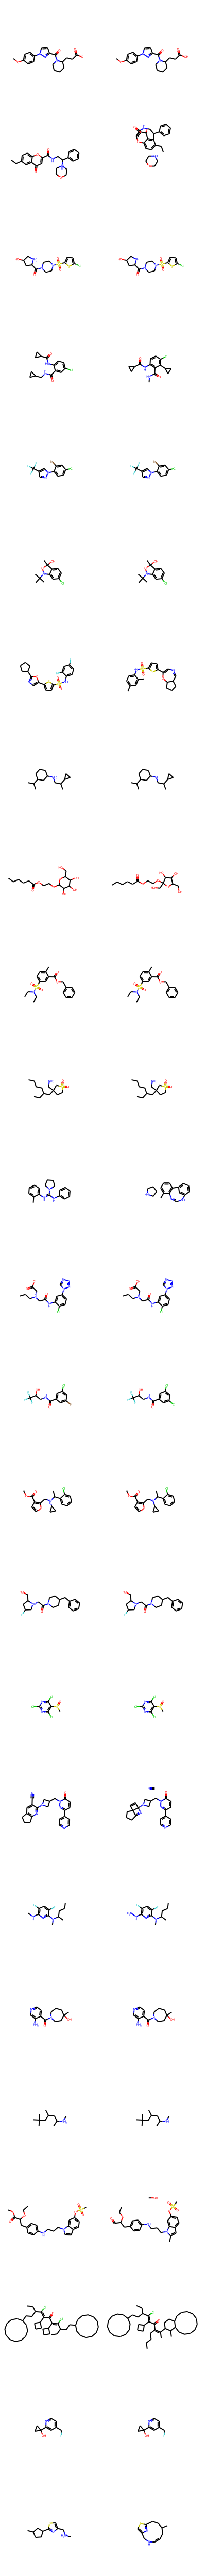

In [19]:
Chem.Draw.MolsToGridImage(mols, molsPerRow=2)

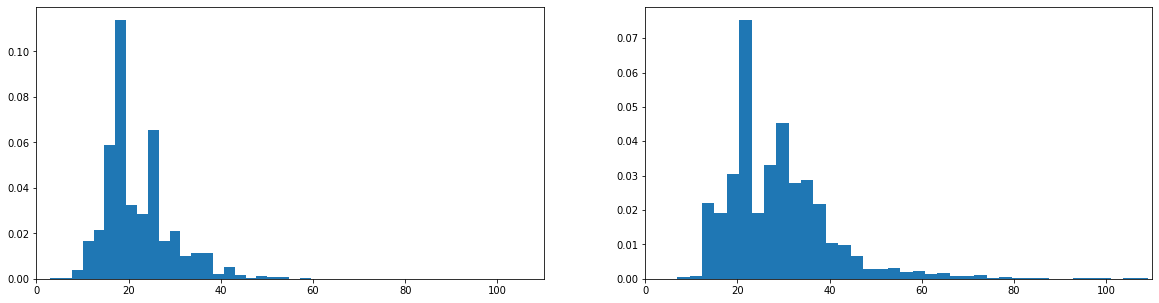

In [20]:
from matplotlib import pyplot as plt
lens = np.asarray([len(dfs_code) for dfs_code in dfs_codes])
plt.figure(figsize=(20,5))
plt.subplot(1,2,1).hist(lens[valid], bins='rice', density=True)
plt.xlim(0, 110)
plt.subplot(1,2,2).hist(lens[True^valid], bins='rice', density=True)
plt.xlim(0, 110)
plt.show()